In [188]:
from path import *
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm

import face_recognition

In [15]:
cnt_dict = dict()
for folder in glob(train_origin_path + '/*'):
    for image_file in glob(folder + '/*'):
        ext = image_file.split('.')[-1]
        cnt_dict[ext] = cnt_dict.get(ext, 0) + 1
print(cnt_dict)

{'jpg': 25765, 'jpeg': 509, 'png': 730}


In [46]:
g = glob(os.path.join(train_image_path, '*'))
len(g)

18900

In [20]:
info = pd.read_csv(os.path.join(train_path, 'train.csv'))
info.head()

id  gender   race  age                    path
0  000001  female  Asian   45  000001_female_Asian_45
1  000002  female  Asian   52  000002_female_Asian_52
2  000004    male  Asian   54    000004_male_Asian_54
3  000005  female  Asian   58  000005_female_Asian_58
4  000006  female  Asian   59  000006_female_Asian_59

In [21]:
len(info)

2700

In [31]:
len(info.id.unique())

2699

In [30]:
len(info.path.unique())

2700

In [37]:
info.id.value_counts()

003397    2
003417    1
005140    1
001099    1
005210    1
         ..
001251    1
005211    1
006371    1
001302    1
001984    1
Name: id, Length: 2699, dtype: int64

In [41]:
info[info.id == '003397']

id  gender   race  age                    path
1366  003397  female  Asian   20  003397_female_Asian_20
1367  003397  female  Asian   19  003397_female_Asian_19

In [22]:
2700 * 7

18900

In [23]:
info.iloc[-1]

id                      006959
gender                    male
race                     Asian
age                         19
path      006959_male_Asian_19
Name: 2699, dtype: object

In [47]:
g[1]

'/opt/ml/input/data/train/images/_all/01_005291_male_Asian_51_5.jpg'

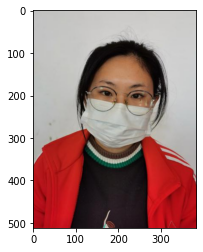

In [92]:
idx = np.random.randint(len(g))
sample = cv2.imread(g[idx])
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
plt.imshow(sample)
plt.show()

In [52]:
sample.shape

(512, 384, 3)

In [94]:
glob(os.path.join(train_image_path, '02*'))[:5]

['/opt/ml/input/data/train/images/_all/02_004373_male_Asian_60_0.jpg',
 '/opt/ml/input/data/train/images/_all/02_001188_male_Asian_60_5.jpg',
 '/opt/ml/input/data/train/images/_all/02_003735_male_Asian_60_3.jpg',
 '/opt/ml/input/data/train/images/_all/02_003981_male_Asian_60_0.jpg',
 '/opt/ml/input/data/train/images/_all/02_004280_male_Asian_60_3.jpg']

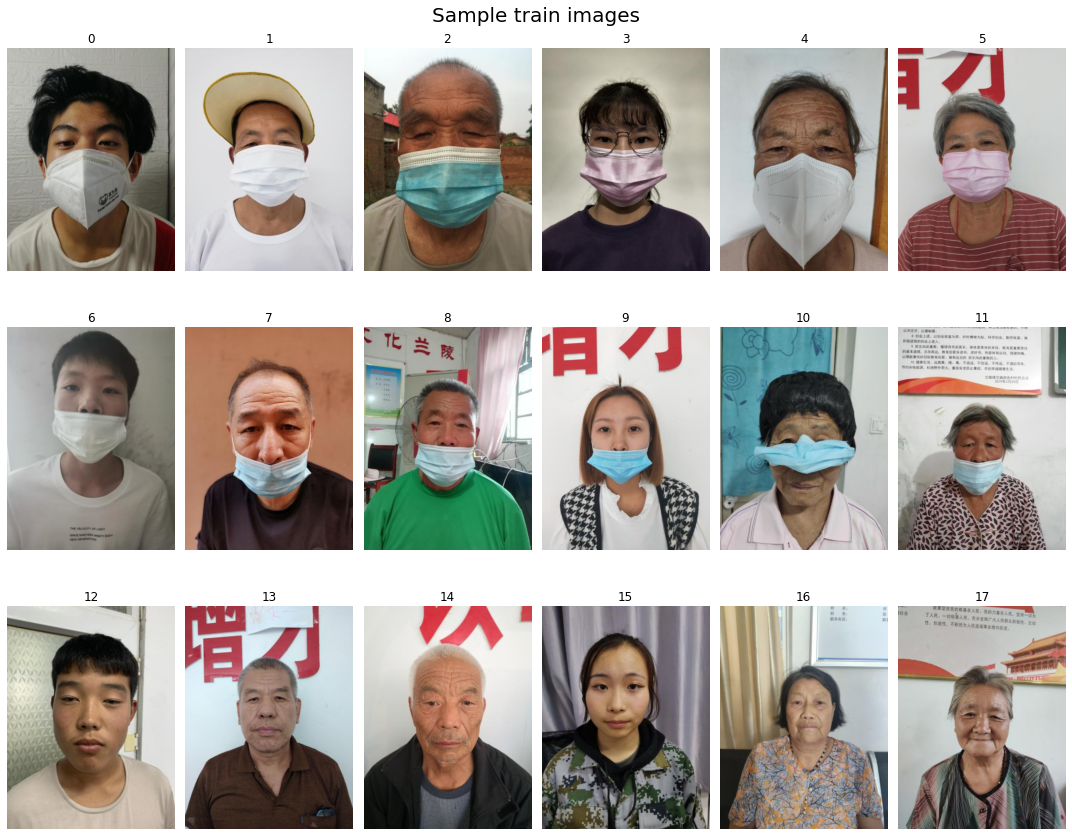

In [198]:
def sample_image(label):
    label = f'{label:02d}'
    candidates = glob(os.path.join(train_image_path, f'{label}*'))
    idx = np.random.randint(len(candidates))
    image = cv2.imread(candidates[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

fig, axes = plt.subplots(3, 6, figsize=(15, 12))
fig.suptitle("Sample train images", fontsize=20, y=1)
for label in range(18):
    r, c = divmod(label, 6)
    subfig = axes[r, c]
    subfig.imshow(sample_image(label))
    subfig.set_title(str(label))
    subfig.axis('off')
plt.tight_layout()
plt.show()

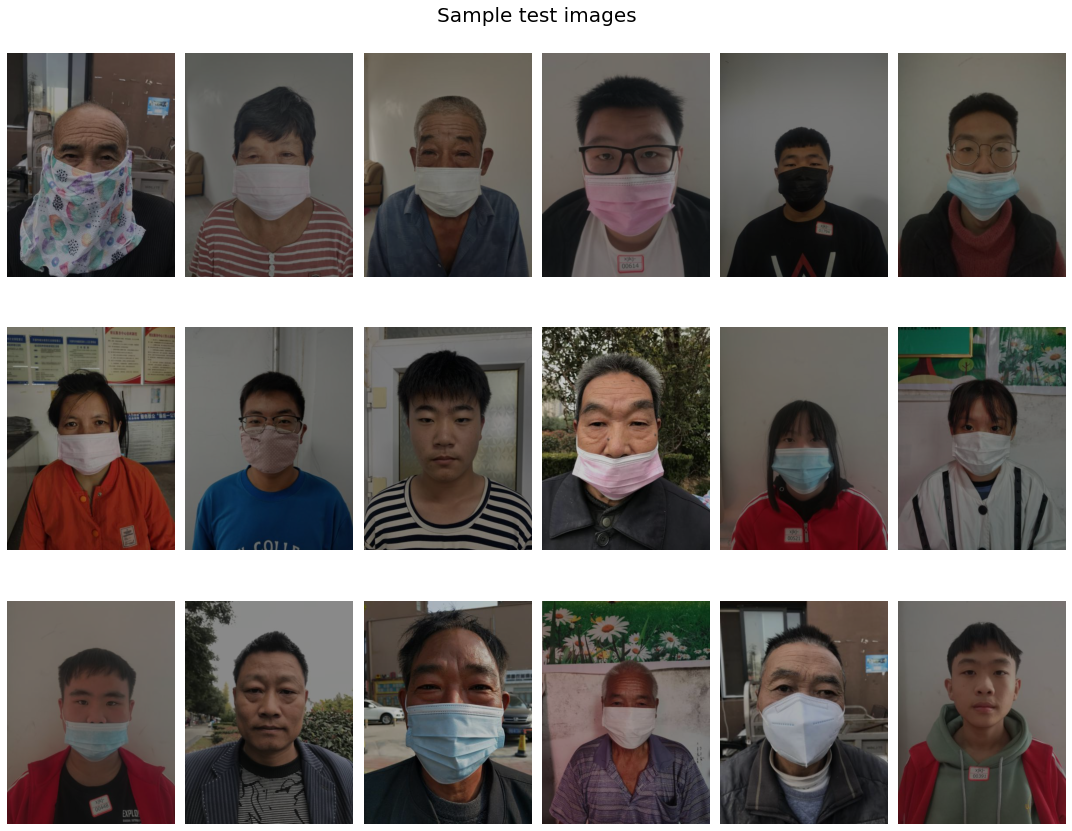

In [200]:
test_images = glob(os.path.join(eval_image_path, '*.jpg'))
test_size = len(test_images)
fig, axes = plt.subplots(3, 6, figsize=(15, 12))
fig.suptitle("Sample test images", fontsize=20, y=1)
for i in range(18):
    idx = np.random.randint(test_size)
    image = test_images[idx]
    image_name = image.split('/')[-1]
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.
    image = cv2.normalize(image, 0, 255)
    r, c = divmod(i, 6)
    subfig = axes[r, c]
    subfig.imshow(image)
    subfig.axis('off')
plt.tight_layout()
plt.show()

In [113]:
images_in_folder = glob(os.path.join(train_origin_path, '001554_female_Asian_27', '*'))
images_in_folder

['/opt/ml/input/data/train/images/001554_female_Asian_27/mask4.jpg',
 '/opt/ml/input/data/train/images/001554_female_Asian_27/normal.jpg',
 '/opt/ml/input/data/train/images/001554_female_Asian_27/mask3.jpg',
 '/opt/ml/input/data/train/images/001554_female_Asian_27/mask1.jpg',
 '/opt/ml/input/data/train/images/001554_female_Asian_27/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/001554_female_Asian_27/mask5.jpg',
 '/opt/ml/input/data/train/images/001554_female_Asian_27/mask2.jpg']

In [106]:
from skimage.exposure import histogram
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.filters import sobel
from skimage.segmentation import watershed

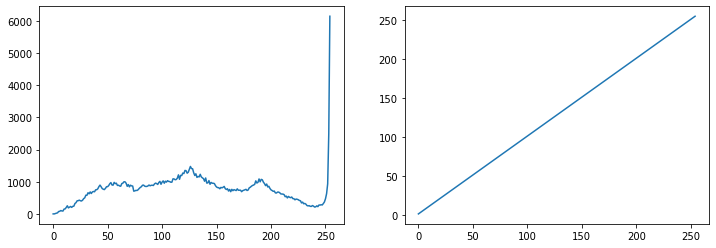

In [108]:
sample = test_images[np.random.randint(len(test_images))]
sample = cv2.imread(sample)
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
hist, hist_centers = histogram(sample)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(hist)
axes[1].plot(hist_centers)
plt.show()

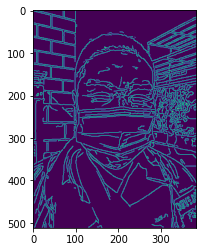

In [79]:
edges = canny(sample/255.)
plt.imshow(edges)

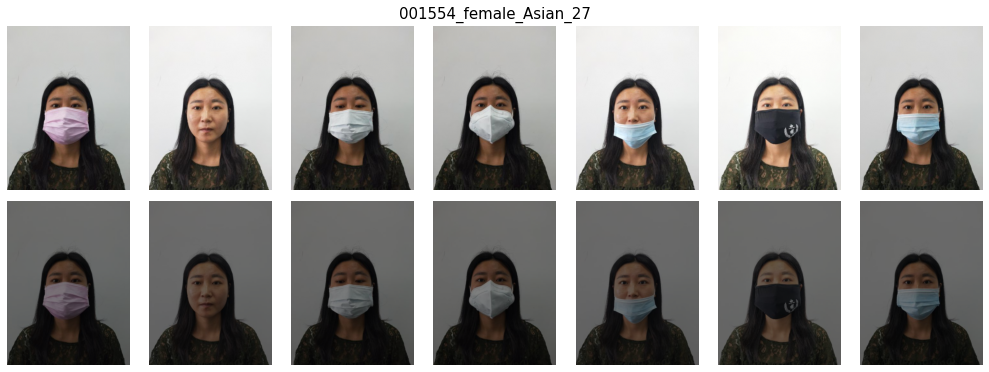

In [179]:
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.filters import sobel
from skimage.segmentation import watershed

all_folders = glob(os.path.join(train_origin_path, '*'))
# random_folder = all_folders[np.random.randint(len(all_folders))]
random_folder = "/opt/ml/input/data/train/images/001554_female_Asian_27"
images_in_folder = glob(os.path.join(random_folder, '*'))

hist = []
hist_n = []

fig, axes = plt.subplots(2, 7, figsize=(14, 5), sharex=True, sharey=True)
fig.suptitle(random_folder.split('/')[-1], fontsize=15, y=1.025)
for i, image_file in enumerate(images_in_folder):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = image / 255.
    image_n = cv2.normalize(image, 0, 255, cv2.NORM_MINMAX)
    
    hist.append(np.mean(image[0], axis=1))
    hist_n.append(np.mean(image_n[0], axis=1))

    axes[0, i].imshow(image)
    axes[1, i].imshow(image_n)
    
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    
plt.tight_layout()
plt.show()

In [178]:
import seaborn as sns

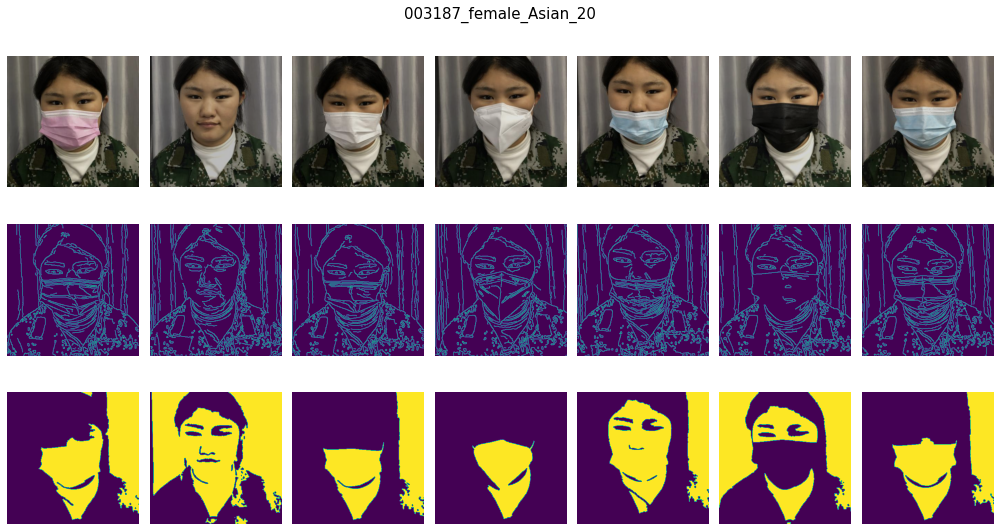

In [197]:
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.filters import sobel
from skimage.segmentation import watershed

all_folders = glob(os.path.join(train_origin_path, '*'))
random_folder = all_folders[np.random.randint(len(all_folders))]
images_in_folder = glob(os.path.join(random_folder, '*'))

fig, axes = plt.subplots(3, 7, figsize=(14, 7.5), sharex=True, sharey=True)
fig.suptitle(random_folder.split('/')[-1], fontsize=15, y=1.025)
for i, image_file in enumerate(images_in_folder):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h, w, _ = image.shape
    cropped = image[h-w:h, 0:w, :]
    gray = cv2.cvtColor(cropped, cv2.COLOR_RGB2GRAY)

    cropped = cropped / 255.
    cropped = cv2.normalize(cropped, 0, 255)

    gray = gray / 255.
    edges = canny(gray)
    
    threshold = (0.28, 0.72)
    markers = np.zeros_like(gray)
    markers[gray < threshold[0]] = 1
    markers[gray > threshold[1]] = 2
    elevation_map = sobel(gray)
    segmentation = watershed(elevation_map, markers)
#     segmentation = ndi.binary_fill_holes(segmentation - 1)

    axes[0, i].imshow(cropped)
    axes[1, i].imshow(edges)
    axes[2, i].imshow(segmentation)
    
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    axes[2, i].axis('off')
    
plt.tight_layout()
plt.show()

In [ ]:
all_folders = glob(os.path.join(train_origin_path, '*'))
random_folder = all_folders[np.random.randint(len(all_folders))]
images_in_folder = glob(os.path.join(random_folder, '*'))

fig, axes = plt.subplots(2, 7, figsize=(15, 7), sharex=True, sharey=True)
fig.suptitle(random_folder.split('/')[-1], fontsize=15)

for i, image_file in enumerate(images_in_folder):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    blur = cv2.GaussianBlur(image, (3, 3), 0)
    gray = cv2.cvtColor(blur, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)
    sure_bg = cv2.dilate(opening, kernel, iterations=1)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.int8(sure_fg)

#     image = image / 255.
#     image_n = cv2.normalize(image, 0, 255)
    image_r = face_recognition.load_image_file(image_file)
    image_r = face_recognition.face_locations(image_r)
    axes[0, i].imshow(image)
    axes[0, i].axis('off')
    axes[1, i].imshow(sure_bg)
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

In [36]:
stats = dict()
for label in range(18):
    group = glob(os.path.join(train_image_path, f"{label:02d}*"))
    stats[label] = len(group)

male, female = 0, 0
correct, incorrect, normal = 0, 0, 0
low, mid, high = 0, 0, 0
for label in stats:
    stat = stats[label]
    
    if label % 6 < 3:
        male += stat
    else:
        female += stat
        
    if label % 3 == 0:
        low += stat
    elif label % 3 == 1:
        mid += stat
    else:
        high += stat
        
    if label < 6:
        correct += stat
    elif label < 12:
        incorrect += stat
    else:
        normal += stat

sum_gender = sum([male, female])
sum_age = sum([low, mid, high])
sum_mask = sum([correct, incorrect, normal])
print(f"Gender   {male / sum_gender:.3f} {female / sum_gender:.3f}")
print(f"Age      {low / sum_age:.3f} {mid / sum_age:.3f} {high / sum_age:.3f}")
print(f"Mask     {correct / sum_mask:.3f} {incorrect / sum_mask:.3f} {normal / sum_mask:.3f}")

Gender   0.386 0.614
Age      0.474 0.454 0.071
Mask     0.714 0.143 0.143


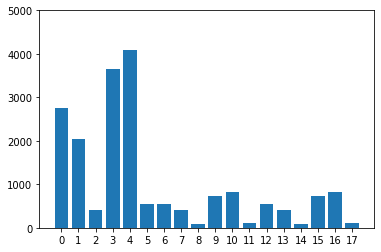

In [220]:
dist = []
for stat in stats.values():
    dist.append(stat)

plt.bar(range(18), dist)
plt.xticks(range(18), range(18))
plt.ylim(0, 5000)
plt.show()

In [137]:
sum(dist)

18900

In [40]:
list(map(lambda x: max(dist) // x, dist))

[1, 1, 9, 1, 1, 7, 7, 9, 49, 5, 5, 37, 7, 9, 49, 5, 5, 37]

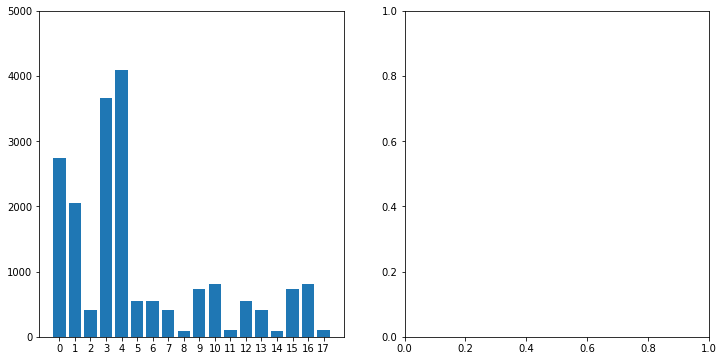

In [218]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
axes[0].bar(range(18), dist)
axes[0].set_xticks(range(18))
axes[0].set_ylim(0, 5000)
plt.show()

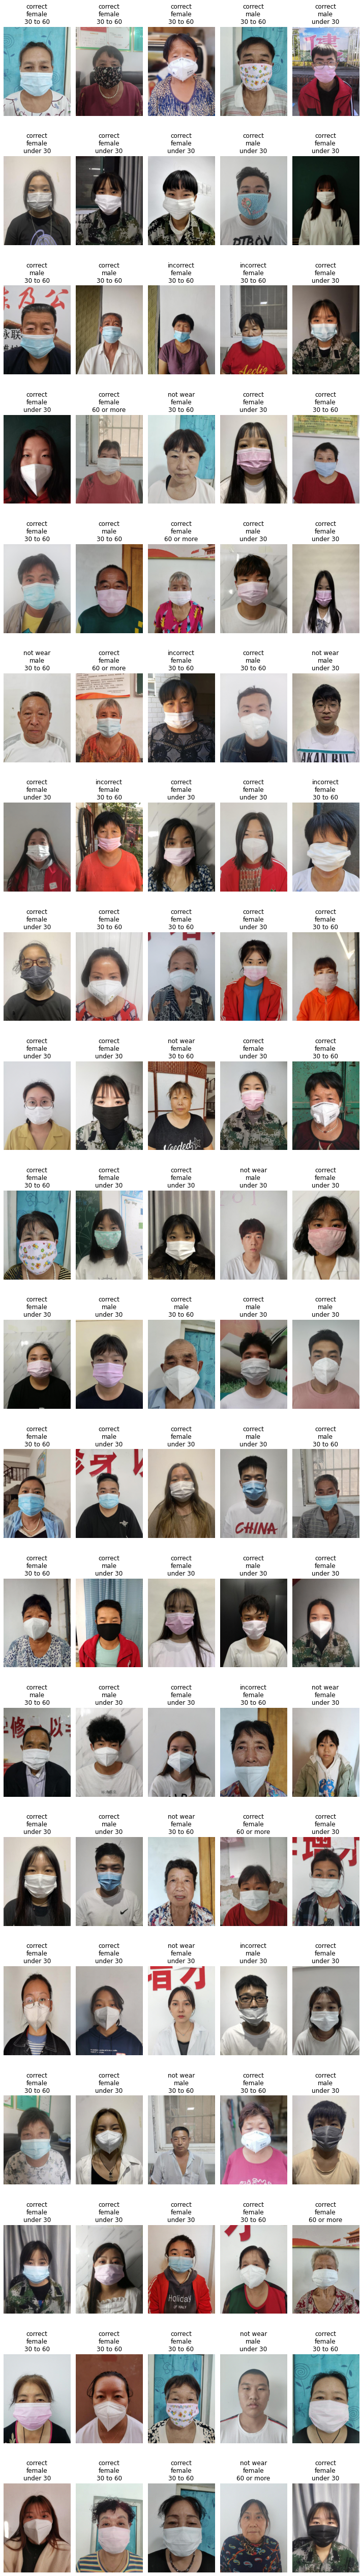

In [223]:
train_images = glob(os.path.join(train_image_path, "*.jpg"))

train_size = len(train_images)
num_samples = 100

fig, axes = plt.subplots(
    num_samples // 5, 5, 
    figsize=(10, 5 * num_samples // 7)
)

for i, idx in enumerate(np.random.randint(0, train_size, num_samples)):
    filename = train_images[idx].split('/')[-1]
    prediction = int(filename[:2])
    
    filepath = os.path.join(train_image_path, filename)
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.
    
    if prediction // 6 == 0:
        mask = 'correct'
    elif prediction // 6 == 1:
        mask = 'incorrect'
    elif prediction // 6 == 2:
        mask = 'not wear'
    
    if (prediction // 3) % 2 == 0:
        gender = 'male'
    else:
        gender = 'female'
        
    if prediction % 3 == 0:
        age = 'under 30'
    elif prediction % 3 == 1:
        age = '30 to 60'
    else:
        age = '60 or more'
    
    r, c = divmod(i, 5)
    axes[r, c].imshow(image)
    axes[r, c].set_title(f"{mask}\n{gender}\n{age}", fontsize=12)
    axes[r, c].axis('off')
    
plt.tight_layout()
plt.show()